## Predicting Wind Power Generation in the PJM RTO Area

### 1. Importing the necesary modules :-

In [1]:
import tensorflow as tf
from tensorflow.keras import layers

In [190]:
import numpy as np
import pandas as pd
import csv
import requests
import time
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Activation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.utils import plot_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from tensorflow import keras

### 2. Import the data :-

In [154]:
wind_actual = pd.read_csv('final_actual.csv')
wind_forecast = pd.read_csv('final_forecast.csv')

In [155]:
wind_forecast.shape

(11336, 3)

In [156]:
wind_actual.shape

(11353, 7)

### 2.a. Merge the data for ease of handling:

In [157]:
data = pd.merge(wind_forecast,wind_actual, on=['Date','HE'])

In [158]:
data=data.set_index('Date')

In [159]:
data.rename(columns={'MW_x':'MW_forecast','MW_y':'MW_actual'}, inplace=True)

In [160]:
data = data[['HE','Area','MW_forecast','MW_actual']]

In [161]:
data.head()

,HE,Area,MW_forecast,MW_actual
Date,,,,
1/1/23,1,RTO,5898.113443,6117.732
1/1/23,2,RTO,6056.121206,6556.513
1/1/23,3,RTO,5191.992898,5901.861
1/1/23,4,RTO,4851.371052,5294.705
1/1/23,5,RTO,5371.115128,4776.355


In [162]:
data = data[data['Area'] == 'RTO']
data = data.drop(columns=['Area'])

data['MW_actual'] = data['MW_actual'].replace(0, np.nan)

data['MW_actual'] = data['MW_actual'].fillna(method='ffill')

X = data[['HE', 'MW_forecast']].values
y = data['MW_actual'].values

In [163]:
X.shape

(11279, 2)

In [164]:
y.shape

(11279,)

In [165]:
X

array([[1.00000000e+00, 5.89811344e+03],
       [2.00000000e+00, 6.05612121e+03],
       [3.00000000e+00, 5.19199290e+03],
       ...,
       [2.20000000e+01, 3.25746100e+03],
       [2.30000000e+01, 2.68694800e+03],
       [2.40000000e+01, 2.26294300e+03]])

### 2.b. Scale the data, separately for X and y so that inverse transform can be applied later:

In [166]:

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1,1))

In [139]:
X_scaled.shape

(11279, 2)

### 2.c. Feature engineering: Create the next 24 hour sequences for each hour of the day data

In [140]:
def create_sequences(X_in, y_in, seq_length):
    X = []
    y = []
    for i in range(len(data)-seq_length-24):  # Adjusted to predict next 24 values
        X.append(X_in[i:i+seq_length, :])  # Exclude last column (MW_actual)
        y.append(y_in[i+seq_length:i+seq_length+24, -1])  # Include only last column (MW_actual)
    return np.array(X), np.array(y)

In [141]:
X, y = create_sequences(X_scaled, y_scaled, 24)

### 2.d. Split data into training and testing sets

In [142]:
split_index = int(X.shape[0] * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [143]:
X_train.shape

(8984, 24, 2)

### Establishing a Baseline using Linear Regression:

In [188]:
X_linReg = data.drop('MW_actual', axis=1)
y_linReg = data['MW_actual']

# Spliting the data into training and testing sets
X_train_linReg, X_test_linReg, y_train_linReg, y_test_linReg = train_test_split(X_linReg, y_linReg, test_size=0.2, random_state=42)

# Initialize and fit the linear regression model
model_linReg = LinearRegression()
model_linReg.fit(X_train_linReg, y_train_linReg)

# Predicting the target variable using X_test
y_pred_linReg = model_linReg.predict(X_test_linReg)

# Evaluating the model
mse_linReg = mean_squared_error(y_test_linReg, y_pred_linReg)
mae_linReg = mean_absolute_error(y_test_linReg, y_pred_linReg)
r2_linReg = r2_score(y_test_linReg, y_pred_linReg)

print("Mean Squared Error:", mse_linReg)
print("Mean Absolute Error:", mae_linReg)
print("R-squared:", r2_linReg)

coefficients_linReg = pd.DataFrame(model_linReg.coef_, X_linReg.columns, columns=['Coefficient'])
print("Coefficients:")
print(coefficients_linReg)

Mean Squared Error: 546039.0878255279
Mean Absolute Error: 580.8568397468945
R-squared: 0.9046816397917244
Coefficients:
             Coefficient
HE             -3.705103
MW_forecast     0.963392


### 3. Define the model:

In [111]:
model = Sequential([
    LSTM(35, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(35, return_sequences=False),
    Dropout(0.2),
    Dense(24),
    Dense(X_train.shape[1]*24//2),
    Activation('linear'),
    Dense(24)  
])

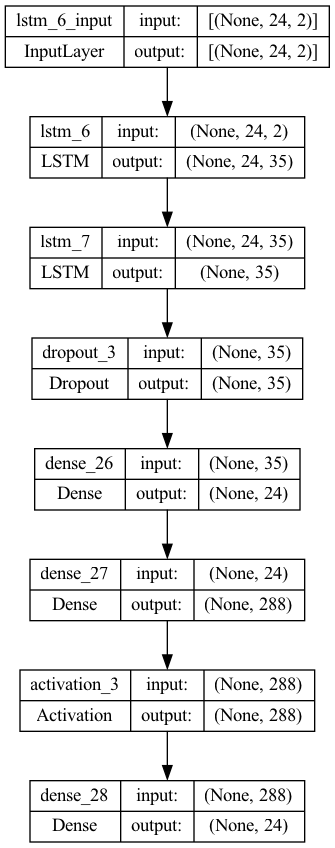

In [112]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### 3.a. Compile and train the model for a 100 epochs

In [113]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_test, y_test), verbose=1)


Epoch 1/100


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x35xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x35xi1>'


138/141 [============================>.] - ETA: 0s - loss: 0.0462

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x24x1x35xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x24x1x35xi1>'


141/141 [==============================] - 18s 63ms/step - loss: 0.0460 - val_loss: 0.0490
Epoch 2/100
141/141 [==============================] - 3s 20ms/step - loss: 0.0343 - val_loss: 0.0432
Epoch 3/100
141/141 [==============================] - 3s 21ms/step - loss: 0.0324 - val_loss: 0.0418
Epoch 4/100
141/141 [==============================] - 3s 21ms/step - loss: 0.0313 - val_loss: 0.0404
Epoch 5/100
141/141 [==============================] - 3s 20ms/step - loss: 0.0309 - val_loss: 0.0417
Epoch 6/100
141/141 [==============================] - 3s 20ms/step - loss: 0.0308 - val_loss: 0.0399
Epoch 7/100
141/141 [==============================] - 3s 20ms/step - loss: 0.0305 - val_loss: 0.0395
Epoch 8/100
141/141 [==============================] - 3s 20ms/step - loss: 0.0304 - val_loss: 0.0381
Epoch 9/100
141/141 [==============================] - 3s 20ms/step - loss: 0.0302 - val_loss: 0.0384
Epoch 10/100
141/141 [==============================] - 3s 20ms/step - loss: 0.0302 - val_los

141/141 [==============================] - 3s 20ms/step - loss: 0.0273 - val_loss: 0.0394
Epoch 81/100
141/141 [==============================] - 3s 20ms/step - loss: 0.0269 - val_loss: 0.0417
Epoch 82/100
141/141 [==============================] - 3s 21ms/step - loss: 0.0269 - val_loss: 0.0409
Epoch 83/100
141/141 [==============================] - 3s 20ms/step - loss: 0.0267 - val_loss: 0.0410
Epoch 84/100
141/141 [==============================] - 3s 21ms/step - loss: 0.0269 - val_loss: 0.0408
Epoch 85/100
141/141 [==============================] - 3s 20ms/step - loss: 0.0266 - val_loss: 0.0423
Epoch 86/100
141/141 [==============================] - 3s 22ms/step - loss: 0.0265 - val_loss: 0.0391
Epoch 87/100
141/141 [==============================] - 3s 19ms/step - loss: 0.0265 - val_loss: 0.0429
Epoch 88/100
141/141 [==============================] - 3s 19ms/step - loss: 0.0264 - val_loss: 0.0451
Epoch 89/100
141/141 [==============================] - 3s 19ms/step - loss: 0.0263 - 

In [167]:
model.save('predictEnergyGen.h5')

### 3.b. Predict the next 24 hours of data:

In [175]:
next_24_hours_data = X_train[-24:,1]
next_24_hours_data.shape

(24, 2)

In [176]:
next_24_hours_data_reshaped = next_24_hours_data.reshape((1, next_24_hours_data.shape[0], next_24_hours_data.shape[1]))
next_24_hours_data_reshaped.shape

(1, 24, 2)

In [177]:
next_24_hours_predictions = model.predict(next_24_hours_data_reshaped)

1/1 [==============================] - 0s 49ms/step


In [178]:
next_24_hours_predictions

array([[0.13476478, 0.14015989, 0.14503202, 0.15027022, 0.16089122,
        0.16886687, 0.1739182 , 0.18871623, 0.20799334, 0.21819942,
        0.22352874, 0.241587  , 0.25826833, 0.26787   , 0.28972834,
        0.30276477, 0.3133539 , 0.31745672, 0.32140976, 0.3209169 ,
        0.31893128, 0.3141392 , 0.3122963 , 0.31240267]], dtype=float32)

In [144]:
new_predictions = next_24_hours_predictions.reshape(-1,1)

In [145]:
inverse_predictions = scaler_y.inverse_transform(new_predictions)

In [203]:
predicted_df = pd.DataFrame(inverse_predictions, columns=['MW'])

In [204]:
predicted_df

,MW
0,1374.539429
1,1428.280640
2,1476.812378
3,1528.990601
4,1634.787231
5,1714.233521
6,1764.550293
7,1911.954834
8,2103.975830
9,2205.639404


### 3.c. Visualize the predicted data:

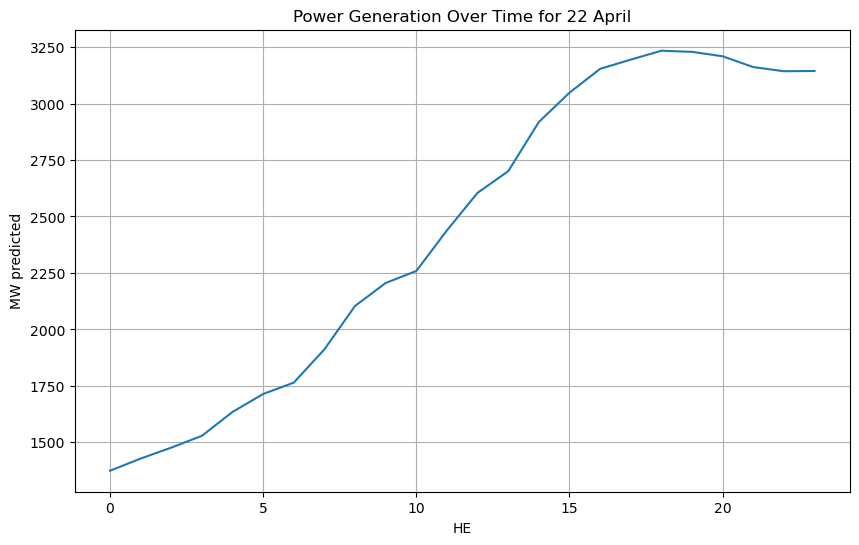

In [206]:
plt.figure(figsize=(10, 6))
plt.plot(predicted_df['MW'])
plt.xlabel('HE')
plt.ylabel('MW predicted')
plt.title('Power Generation Over Time for 22 April')
plt.grid(True)
plt.show()

In [207]:

predicted_df['HE'] = range(1, len(predicted_df) + 1)


predicted_df['Area'] = 'RTO'

In [208]:
predicted_df.to_csv("2024-04-22_Pred_Riddhi_Pathak.csv")

### 4. Use the test data to predict and gauge accuracy of the data:

In [123]:
#X_test
y_pred = model.predict(X_test)

71/71 [==============================] - 1s 13ms/step


In [171]:
X_test.shape

(2247, 24, 2)

In [124]:
y_pred.shape

(2247, 24)

In [148]:
mae = mean_absolute_error(y_test, y_pred)

mse = mean_squared_error(y_test, y_pred)

rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 0.16304688832223801
Mean Squared Error (MSE): 0.042177214918056295
Root Mean Squared Error (RMSE): 0.19840112266111257


### Thus, we see that our model has significantly improved compared to the linear regression.

### ***FIN.***